In [1]:
#functions

import math
import random


# makes a ticket
def ticket_generator(t, o, a):
    ticket={
        'time': t,
        'owner': o,
        'action': a,
    }
    return ticket;


# depending on parameter (spread or cure), generates tau
def nextTime(rateParameter, n):
    taus=[0]*n
    for i in range(0,n): #start at zero, stops just short of n
        taus[i]=-math.log(1.0 - random.random()) / rateParameter #math.log is in base e, and random.random picks a number from range 0.0 to 1.
    return taus #generates n-length list, starting at index 0


#writes the edges to a network of n ppl where everyone is connected to everyone else 
def network_writer(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network

#Checks the proportion of agents in infected state at regular intervals
def timechecktickethandler(prop_inf, ppl_state, num_ppl, check_acc):
    prop_inf[check_acc]=sum(ppl_state)/num_ppl


#ONCE NETWORKS ARE NOT SMALL WORLD, WILL NEED TO PASS IN CONNECT TO FUNCTION TO SEE WHO CAN BE INFECTED BY THE OWNER 
#(ow) AND TO GENERATE THE CORRECT LENGTH FOR Ts

#processes spread/infection tickets, returning a new timeline (with added tickets) and an updated list of states
def spreadtickethandler(tic, timeline, spreadparam, cureparam, ppl_state, t_max): 
    ow=tic['owner']
    targ=tic['action'] #this action should not be -1 bc this is passed to spread ticket handler
    if (ow==targ):
        print('Error -- ow=targ, {:d}={:d}' .format(ow,targ)) 

#The spreadtickethandler function is broken into 4 steps, as outlined in appendix B.1.2 of 
#Ruud VAN DE BOVENKAMP's thesis (p. 158)
        
#1
    if(ppl_state[ow]!=1):
        print('Error -- individual {:d} is not infected, but was passed to spreadtickethandler!' .format(ow))
    else:
#2
        t=tic['time']
        if(ppl_state[targ]==1):
            print('{:d} is already infected! at time {:f}' .format(targ,t)) 
        else:
            ppl_state[targ]=1 #Set targ to be infected
            num_ppl=len(ppl_state) #number of people
            ts=[t]*(num_ppl-1) #list of t repeated num_ppl-1 times
            nT=nextTime(spreadparam, num_ppl-1) #generates taus
            cure_t=t+nextTime(cureparam, 1)[0] #using [0] in order to add an integer to t
            spread_ts=[sum(x) for x in zip(ts,nT)] 
            acc=0 #accumulator initialized
            for a in connect[targ]: #Go through all of targ's connections and create spread tickets as necessary
                if(spread_ts[acc]<cure_t and spread_ts[acc]<t_max): #if the spread time occurs before targ is cured and does not exceed t_max
                    tinf=ticket_generator(spread_ts[acc], targ, a) #generate spread ticket
                    add_to_timeline(tinf, timeline) #add spread ticket to timeline
                acc=acc+1 #accumulator incremented
            if cure_t<t_max: #if the cure time doesn't exceed t_max
                tcure=ticket_generator(cure_t, targ, -1) #generate cure ticket
                add_to_timeline(tcure, timeline) #add cure ticket to timeline
#3
        #in our code, timechecktickethandler checks the infected count at certain time intervals
#4
        spread_t2=t+nextTime(spreadparam,1)[0] #spread_t2 is the time for respreading from ow to targ
        cure_t_ow=t_max+1 #just so we don't get an error on line 91 if cure_t_ow isn't generated in the while loop bc it's too big
        i=timeholder #timeholder is index of timeline
        curefound=0 #a flag for the while loop
        #looking for the curetime of each individual
        while curefound==0 and i<(len(timeline)-1): #while cure is not found and we aren't beyond last index of timeline
            tim=timeline[i]
            if(tim['owner']==ow): 
                if(tim['action']==-1): #-1 is action associated with cure tickets
                    cure_t_ow=tim['time'] #set cure time of owner
                    curefound=1 #stop when cure is found
            i=i+1 
        if(spread_t2<cure_t_ow and spread_t2<t_max): #if re-infection spread time is less cure time of owner and doesn't exceed t_max
            spread2tic=ticket_generator(spread_t2, ow, targ) #make a spread ticket for re-infection of targ by ow
            add_to_timeline(spread2tic, timeline) #add spread ticket to timeline
        return [timeline, ppl_state];
            
        
    
#processes cure tickets, returning the new states of ppl        
def curetickethandler(tic, ppl_state):
    ow=tic['owner']
    ppl_state[ow]=0
    return ppl_state

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def add_to_timeline(tic, tim):
    if not tim:
        return [tic]
    ind=len(tim)-1
    end=0
    while (tic['time']<tim[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
        ind=ind-1 
        if(ind<0):
            end=1
    ind=ind+1
    tim.insert(ind, tic)
    return tim

#adjusts ind so times can match with nodes correctly (accounts for the fact that in connections, owner is omitted)
def new_ind(ind, ow):
    if(ind>ow):
        ind=ind-1
    return ind

In [2]:
#NOTE: be able to start w whatever # of sick ppl we want
#main -- uses functions described above to simulate SIS dynamics over time using agent based model
random.seed(4)
t_max=10 #we want to go to 2 time units (trust us, it still takes a while)
sick_ind=0 #we will set individual 0 to start out sick, but could also use random number generator
spreadparam=.1 
cureparam=3
#curetimearray=[]; #DELETE!!!
timeline=[] #initialize empty timeline
num_ppl=100 #set # of agents
ppl_state=[0]*num_ppl #make a record of everyone's state, starting with all succeptible except...
ppl_state[sick_ind]=1 #starting with 1 infected person, sick_ind
connect=network_writer(num_ppl) #make a network of connections btwn the ppl -- everyone is connected to everyone rn
tinfinit=nextTime(spreadparam, num_ppl-1) #generate the time of the first infection THIS IS NOW ALL THE TIMES -- one for each
tcureinit=nextTime(cureparam, 1)[0] #generate the time of sick_ind's cure
while(all(i < tcureinit for i in tinfinit)): #for the very rare case that no individuals get infected before individual 0 gets cured
    tcureinit=nextTime(cureparam,1) #ensure that that time occurs after patient 0 has infected someone -- just so our sim goes somewhere

smallinds=[] #isolate only those times that are smaller than cure time  
acc=0
for i in connect[sick_ind]:        
    if tinfinit[acc]<tcureinit:
        smallinds.append(i)
    acc=acc+1  
for i in range (len(smallinds)):
    init_inf=ticket_generator(tinfinit[new_ind(smallinds[i], sick_ind)], sick_ind, smallinds[i])#generate a ticket for the first infection 
    timeline=add_to_timeline(init_inf, timeline) #put these 2 tickets on timeline
#we will probably change the above 9 lines to be like what we do in spreadtickethandler, which is more intuitive


init_cure=ticket_generator(tcureinit, sick_ind, -1) # generate a ticket for the first cure
timeline=add_to_timeline(init_cure, timeline) #add it to timeline
l=list(range(0, (t_max)*100, 1))
l2=[.01]*len(l)
check_times=[a*b for a,b in zip(l,l2)] #our list goes from 0 to tmax with intervals of .1
for i in check_times:
    tchecktic=ticket_generator(i, -2, -2) #-2 here indicates that this is a time-check ticket
    add_to_timeline(tchecktic, timeline) #add to timeline
prop_inf=[0]*len(check_times) #initialize proportion infected storage vector
timeholder=0 #timeholder is the index where we are on the timeline (start at 0)
t=0 #we start at a time of 0 
check_acc=0 #accumulator to help us index prop_inf



In [3]:
#main ct'd

while t<t_max:
    #print(t)
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        #print(sum(ppl_state)/num_ppl)
        print('end')
        break
    nexttic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    if (nexttic['action']==-1): #if it's a cure ticket, use the corresponding handler
        ppl_state=curetickethandler(nexttic, ppl_state) #handler returns ppl_state
    elif nexttic['action']==-2: #if it's a time check ticket use the corresponding handler
        timechecktickethandler(prop_inf, ppl_state, num_ppl, check_acc) #fills in prop_inf
        check_acc=check_acc+1 #increment accumulator
    else: #if it's a spread ticket, use the corresponding handler
        vec=spreadtickethandler(nexttic, timeline, spreadparam, cureparam, ppl_state, t_max)
        timeline=vec[0] #returns updated timeline
        ppl_state=vec[1] #and updated ppl_state
    t=nexttic['time'] #new time based on the ticket we just read

    
    timeholder=timeholder+1 #increment timeholder
    


46 is already infected! at time 0.309168
46 is already infected! at time 0.451492
85 is already infected! at time 0.467493
83 is already infected! at time 0.471503
83 is already infected! at time 0.482003
21 is already infected! at time 0.540331
25 is already infected! at time 0.587571
88 is already infected! at time 0.614032
21 is already infected! at time 0.614280
67 is already infected! at time 0.614851
93 is already infected! at time 0.623828
96 is already infected! at time 0.628337
93 is already infected! at time 0.629794
35 is already infected! at time 0.634895
95 is already infected! at time 0.636142
55 is already infected! at time 0.638525
88 is already infected! at time 0.651200
46 is already infected! at time 0.666242
79 is already infected! at time 0.683737
83 is already infected! at time 0.690070
62 is already infected! at time 0.690837
86 is already infected! at time 0.699483
84 is already infected! at time 0.704611
82 is already infected! at time 0.710083
83 is already in

62 is already infected! at time 1.268348
66 is already infected! at time 1.268668
27 is already infected! at time 1.270326
65 is already infected! at time 1.275449
3 is already infected! at time 1.277979
32 is already infected! at time 1.278698
13 is already infected! at time 1.279563
52 is already infected! at time 1.281453
12 is already infected! at time 1.285740
96 is already infected! at time 1.286412
93 is already infected! at time 1.287149
91 is already infected! at time 1.287879
33 is already infected! at time 1.290389
97 is already infected! at time 1.296331
49 is already infected! at time 1.298750
52 is already infected! at time 1.299748
32 is already infected! at time 1.300395
47 is already infected! at time 1.301619
23 is already infected! at time 1.302081
86 is already infected! at time 1.302468
65 is already infected! at time 1.310087
48 is already infected! at time 1.310871
99 is already infected! at time 1.312502
56 is already infected! at time 1.318160
66 is already inf

1 is already infected! at time 2.120410
50 is already infected! at time 2.121522
32 is already infected! at time 2.123398
16 is already infected! at time 2.124298
43 is already infected! at time 2.125996
75 is already infected! at time 2.127226
84 is already infected! at time 2.127512
69 is already infected! at time 2.127587
39 is already infected! at time 2.127837
45 is already infected! at time 2.130462
4 is already infected! at time 2.130689
67 is already infected! at time 2.131754
86 is already infected! at time 2.134396
4 is already infected! at time 2.147019
77 is already infected! at time 2.147662
98 is already infected! at time 2.149829
29 is already infected! at time 2.150465
56 is already infected! at time 2.150691
88 is already infected! at time 2.152765
56 is already infected! at time 2.153865
49 is already infected! at time 2.155484
37 is already infected! at time 2.156142
91 is already infected! at time 2.162076
91 is already infected! at time 2.162641
91 is already infec

77 is already infected! at time 2.881244
31 is already infected! at time 2.881785
80 is already infected! at time 2.882383
37 is already infected! at time 2.884263
46 is already infected! at time 2.887621
38 is already infected! at time 2.887802
48 is already infected! at time 2.889623
64 is already infected! at time 2.899894
27 is already infected! at time 2.899968
3 is already infected! at time 2.903391
88 is already infected! at time 2.904815
28 is already infected! at time 2.904888
85 is already infected! at time 2.907310
32 is already infected! at time 2.910723
98 is already infected! at time 2.913145
70 is already infected! at time 2.918988
70 is already infected! at time 2.919256
97 is already infected! at time 2.923924
23 is already infected! at time 2.926098
85 is already infected! at time 2.929329
76 is already infected! at time 2.929502
38 is already infected! at time 2.931156
46 is already infected! at time 2.931474
48 is already infected! at time 2.931685
77 is already inf

66 is already infected! at time 3.792486
48 is already infected! at time 3.793938
2 is already infected! at time 3.794764
41 is already infected! at time 3.796302
68 is already infected! at time 3.796542
41 is already infected! at time 3.797397
54 is already infected! at time 3.801062
68 is already infected! at time 3.802466
73 is already infected! at time 3.802966
78 is already infected! at time 3.803729
17 is already infected! at time 3.808491
52 is already infected! at time 3.815565
54 is already infected! at time 3.816830
98 is already infected! at time 3.816977
22 is already infected! at time 3.822841
52 is already infected! at time 3.822947
8 is already infected! at time 3.826954
44 is already infected! at time 3.830560
52 is already infected! at time 3.831488
95 is already infected! at time 3.834819
68 is already infected! at time 3.835128
42 is already infected! at time 3.841038
83 is already infected! at time 3.841841
54 is already infected! at time 3.844887
12 is already infe

83 is already infected! at time 4.845740
22 is already infected! at time 4.849773
91 is already infected! at time 4.851776
84 is already infected! at time 4.854711
26 is already infected! at time 4.854956
74 is already infected! at time 4.856652
91 is already infected! at time 4.858934
84 is already infected! at time 4.859628
26 is already infected! at time 4.862994
36 is already infected! at time 4.863231
57 is already infected! at time 4.865569
39 is already infected! at time 4.869060
62 is already infected! at time 4.869241
24 is already infected! at time 4.873191
73 is already infected! at time 4.874288
31 is already infected! at time 4.876306
76 is already infected! at time 4.878516
79 is already infected! at time 4.883185
84 is already infected! at time 4.885088
10 is already infected! at time 4.889270
46 is already infected! at time 4.890226
65 is already infected! at time 4.890977
23 is already infected! at time 4.896463
66 is already infected! at time 4.902724
40 is already in

55 is already infected! at time 5.271409
54 is already infected! at time 5.274770
77 is already infected! at time 5.276214
62 is already infected! at time 5.276358
76 is already infected! at time 5.276615
55 is already infected! at time 5.278783
13 is already infected! at time 5.279881
82 is already infected! at time 5.284009
31 is already infected! at time 5.285080
49 is already infected! at time 5.285740
81 is already infected! at time 5.287827
76 is already infected! at time 5.291684
33 is already infected! at time 5.292364
63 is already infected! at time 5.295744
62 is already infected! at time 5.295948
19 is already infected! at time 5.298946
22 is already infected! at time 5.301108
33 is already infected! at time 5.304955
28 is already infected! at time 5.307681
60 is already infected! at time 5.309033
9 is already infected! at time 5.309685
87 is already infected! at time 5.310457
5 is already infected! at time 5.312532
17 is already infected! at time 5.313481
88 is already infe

80 is already infected! at time 6.044046
3 is already infected! at time 6.047145
78 is already infected! at time 6.050613
84 is already infected! at time 6.052916
90 is already infected! at time 6.053243
39 is already infected! at time 6.053468
49 is already infected! at time 6.055506
93 is already infected! at time 6.058056
71 is already infected! at time 6.058515
79 is already infected! at time 6.059890
79 is already infected! at time 6.062213
50 is already infected! at time 6.063516
26 is already infected! at time 6.072070
4 is already infected! at time 6.073156
81 is already infected! at time 6.073184
45 is already infected! at time 6.075624
35 is already infected! at time 6.077595
60 is already infected! at time 6.080153
47 is already infected! at time 6.080814
80 is already infected! at time 6.081164
50 is already infected! at time 6.081661
28 is already infected! at time 6.083084
25 is already infected! at time 6.085671
7 is already infected! at time 6.086507
14 is already infec

16 is already infected! at time 7.030563
14 is already infected! at time 7.034576
71 is already infected! at time 7.035137
80 is already infected! at time 7.036012
91 is already infected! at time 7.037502
80 is already infected! at time 7.038750
79 is already infected! at time 7.040564
56 is already infected! at time 7.041765
88 is already infected! at time 7.049671
46 is already infected! at time 7.049875
17 is already infected! at time 7.051656
99 is already infected! at time 7.057325
13 is already infected! at time 7.058603
10 is already infected! at time 7.062633
23 is already infected! at time 7.063480
33 is already infected! at time 7.063510
27 is already infected! at time 7.063720
9 is already infected! at time 7.068742
26 is already infected! at time 7.071302
87 is already infected! at time 7.071488
28 is already infected! at time 7.073655
66 is already infected! at time 7.074763
18 is already infected! at time 7.080706
58 is already infected! at time 7.082446
33 is already inf

23 is already infected! at time 8.442443
22 is already infected! at time 8.443474
78 is already infected! at time 8.448331
22 is already infected! at time 8.449849
49 is already infected! at time 8.452286
84 is already infected! at time 8.454552
36 is already infected! at time 8.455283
95 is already infected! at time 8.456776
88 is already infected! at time 8.458273
2 is already infected! at time 8.460383
79 is already infected! at time 8.462106
35 is already infected! at time 8.462721
9 is already infected! at time 8.462883
2 is already infected! at time 8.463977
78 is already infected! at time 8.464378
81 is already infected! at time 8.464677
82 is already infected! at time 8.466677
87 is already infected! at time 8.466948
68 is already infected! at time 8.467562
5 is already infected! at time 8.469001
82 is already infected! at time 8.473011
38 is already infected! at time 8.475513
66 is already infected! at time 8.476957
66 is already infected! at time 8.477382
63 is already infect

74 is already infected! at time 9.435950
42 is already infected! at time 9.437160
54 is already infected! at time 9.439295
42 is already infected! at time 9.442006
0 is already infected! at time 9.442194
73 is already infected! at time 9.444216
52 is already infected! at time 9.445254
68 is already infected! at time 9.446897
16 is already infected! at time 9.448503
67 is already infected! at time 9.451328
51 is already infected! at time 9.453168
95 is already infected! at time 9.454707
44 is already infected! at time 9.455097
14 is already infected! at time 9.455675
98 is already infected! at time 9.456063
42 is already infected! at time 9.456214
26 is already infected! at time 9.456394
23 is already infected! at time 9.457003
62 is already infected! at time 9.458964
62 is already infected! at time 9.459359
54 is already infected! at time 9.462655
71 is already infected! at time 9.464109
74 is already infected! at time 9.465259
59 is already infected! at time 9.466571
15 is already inf

In [4]:

#print(timeline)

{'time': 0.37889288229640894, 'owner': 84, 'action': -1}


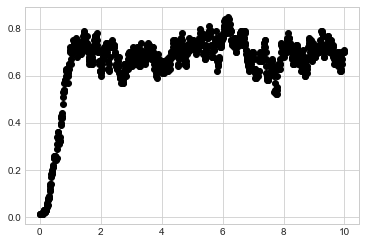

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

plt.plot(check_times, prop_inf, 'o', color='black');
